# Generating Artificial, BigBird like, Sparse Matrices
### *By Shane Donnelly*

## Previous work
# What is BigBird?
BigBird, is a sparse-attention based transformer which extends Transformer based models, such as BERT to much longer sequences. Moreover, BigBird comes along with a theoretical understanding of the capabilities of a complete transformer that the sparse model can handle.

As a consequence of the capability to handle longer context,
BigBird drastically improves performance on various NLP tasks such as question answering and summarization.

![Previous work](./previous_work_reduce.png "Previous work")


## Introduction 

My goal was to generate python functions, using only math, numpy and pure python, with a algorithm approche, simplicity and easy to port to C.
For each attention mask (a, b, c and d ), i have written the following features : 
- generate a boolean mask, using the corresponding parameter
- same, but based on a given sparsity (by having a function : given sparsity -> corresponding parameter)
- generate artificial matrix of only ones and zero based on the mask
- a test function which shows how to use it and the output

## Code

#### Imports

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import math

## UTILS

In [173]:
def get_nb_non_zero(matrix):
    return np.count_nonzero(matrix)

In [174]:
def get_density(matrix, size):
    return float(get_nb_non_zero(matrix)) / float(size * size)

In [175]:
def get_sparsity(matrix, size):
    return 1.0 - get_density(matrix, size)

In [176]:
def show_matrix_infos(matrix, size, given_sparsity = -1.0): # -1.0 correspond to None.
    # conditions : shape(matrix) = (size, size)
    real_sparsity = get_sparsity(matrix, size)
    given_text = "None" if given_sparsity < 0 else f"{given_sparsity:.2f}"
    text = f"size: {size}, Given Sparsity: {given_text}, Real Sparsity: {real_sparsity:.4f}"
    plt.title(label=text)
    plt.imshow(matrix, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

## RANDOM ATTENTION

### By number of non-zeros per row

In [177]:
def get_random_attention_mask(size, nz_per_row):
    # conditions : nz_per_row <= size
    rng = np.random.default_rng(121263137472525314065)
    mask = rng.multivariate_hypergeometric([1]*size, nz_per_row, size=size).astype(bool)
    return mask

In [178]:
def generate_matrix_with_random_attention_mask(size, nz_per_row):
    # conditions : nz_per_row <= size
    matrix = np.ones((size, size))
    mask = get_random_attention_mask( size=size, nz_per_row=nz_per_row)
    matrix[~mask] = 0
    return matrix

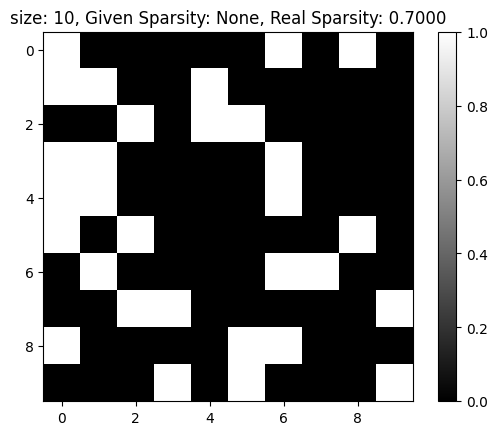

In [179]:
def test_generate_matrix_with_random_attention_mask():
    size = 10
    nz_per_row = 3
    matrix = generate_matrix_with_random_attention_mask(size=size, nz_per_row=nz_per_row)
    show_matrix_infos(matrix=matrix, size=size)

test_generate_matrix_with_random_attention_mask()

### By sparsity

In [180]:
def best_nz_per_row_from_sparsity(size, sparsity):
    # conditions : 0 <= sparsity <= 1
    return round(size * (1 - sparsity))

In [181]:
def get_random_attention_mask_with_sparsity(size, sparsity):
    # conditions : 0 <= sparsity <= 1
    nz_per_row=best_nz_per_row_from_sparsity(size=size, sparsity=sparsity)
    return get_random_attention_mask( size=size, nz_per_row=nz_per_row)

In [182]:
def generate_matrix_with_random_attention_mask_with_sparsity(size, sparsity):
    # conditions : 0 <= sparsity <= 1
    matrix = np.ones((size, size))
    mask = get_random_attention_mask_with_sparsity(size=size, sparsity= sparsity)
    matrix[~mask] = 0
    return matrix

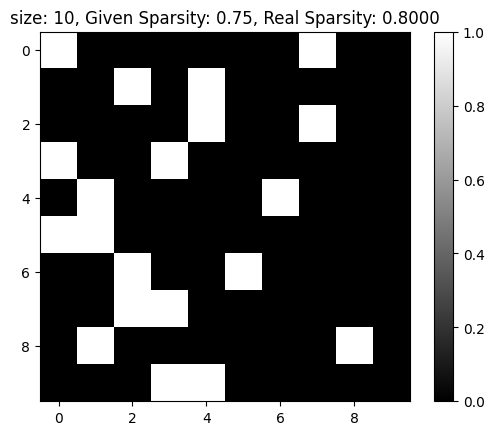

In [194]:
def test_generate_matrix_with_random_attention_mask_with_sparsity():
    size = 10
    sparsity = 0.75
    matrix = generate_matrix_with_random_attention_mask_with_sparsity(size=size, sparsity=sparsity)
    show_matrix_infos(matrix=matrix, size=size, given_sparsity=sparsity)

test_generate_matrix_with_random_attention_mask_with_sparsity()

## WINDOW ATTENTION

![Tridiagonal matrix Image](tridiagonal_matrix_reduce.png "Tridiagonal matrix")

### Utils

In [184]:
def diagonal_area(size,diagonal_width):
    # conditions : size
    if(diagonal_width == 0):
        return 0
    else:
        n = size
        #semi diagonal widht
        sdw = diagonal_width // 2 # (diagonal_width / 2 - 1 because is odd)
        da = n * ( 1 + 2 * sdw ) - sdw * (sdw + 1)
        return da

### By diagonal width

In [185]:
def get_window_attention_mask (size, diagonal_width):
    # conditions : shape(matrix) = (size, size), 0 <= diagonal_width <= 2*size - 1 (cover full matrix), diagonal_width is odd
    mask = np.zeros(shape=(size, size), dtype=bool)
    if (diagonal_width > 0):
        sdw = diagonal_width // 2
        if diagonal_width == 1:
            mask = np.fromfunction(lambda i, j:  j == i,shape=(size, size), dtype=int)
        else : 
            mask = np.fromfunction(lambda i, j:  np.abs(i - j) <= sdw ,shape=(size, size), dtype=int)
    return mask
    

In [186]:
def generate_matrix_with_window_attention_mask(size, diagonal_width):
    # conditions :  0 <= diagonal_width <= 2*size - 1 (cover full matrix), diagonal_width is odd
    matrix = np.ones((size, size))
    mask = get_window_attention_mask( size= size, diagonal_width=diagonal_width)
    matrix[~mask] = 0
    return matrix

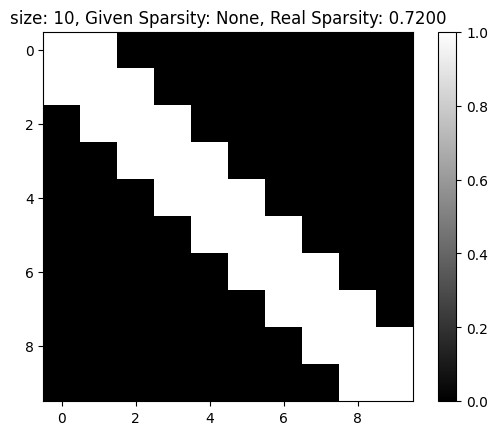

In [187]:
def test_generate_matrix_with_window_attention_mask():
    size = 10
    diagonal_width = 3
    matrix = generate_matrix_with_window_attention_mask(size=size, diagonal_width=diagonal_width)
    show_matrix_infos(matrix,size)

test_generate_matrix_with_window_attention_mask()

### By sparsity

In [188]:
def best_diagonal_width_from_sparsity(size, sparsity):
    n = size
    density = 1.0 - sparsity
     # ideal diagonal aera
    da = n * n * density
    # from this point, all is explained in the related document
    a = -1
    b = 2 * n - 1
    c = n - da
    det = b * b - 4 * a * c
    x = (-b + math.sqrt(det))/(2 * a)
    
    sdw = round(x)
    
    dw = 2 * sdw + 1
    
    if(dw < 0) : dw = 0
    elif(dw > 2*n - 1): dw = 2*n - 1
    # print(f"For matrix of size: {n} and given sparsity: {sparsity}, ideal semi diagonal width is : {x}, chosen dw is {dw}")
    return dw    

In [189]:
def test_diagonal_width_from_sparsity():
    sparsity_values = [x / 100.0 for x in range(0, 101, 5)]
    sizes = [10, 100, 250, 500, 1000]
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    
    plt.figure(figsize=(6, 6))

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='y=x')

    for size, color in zip(sizes, colors):
        given_sparsity = []
        real_sparsity = []
        
        for sparsity in sparsity_values:
            da = best_diagonal_width_from_sparsity(size, sparsity)
            real_sp = 1.0 - (float(diagonal_area(size, da)) / float(size * size))
            given_sparsity.append(sparsity)
            real_sparsity.append(real_sp)
        
        plt.plot(given_sparsity, real_sparsity, 'o-', color=color, label=f'n={size}')
    plt.xlabel('Given Sparsity')
    plt.ylabel('Real Sparsity')
    plt.legend()
    plt.grid(True)
    plt.show()

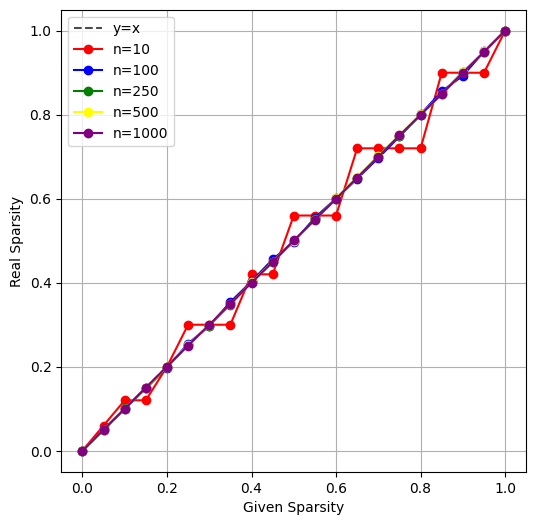

In [190]:
# test function hided for render
test_diagonal_width_from_sparsity()

In [191]:
def get_window_attention_mask_with_sparsity( size, sparsity):
    # conditions : 0 <= sparsity <= 1
    dw = best_diagonal_width_from_sparsity(size, sparsity)
    return get_window_attention_mask( size=size, diagonal_width=dw)

In [192]:
def generate_matrix_with_window_attention_mask_with_sparsity(size, sparsity):
    # conditions :  0 <= diagonal_width <= 2*size - 1 (cover full matrix), diagonal_width is odd
    matrix = np.ones((size, size))
    mask = get_window_attention_mask_with_sparsity( size= size, sparsity=sparsity)
    matrix[~mask] = 0
    return matrix

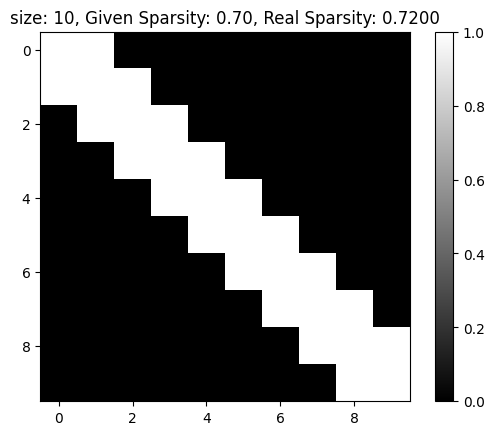

In [193]:
def test_generate_matrix_with_window_attention_mask_with_sparsity():
    size = 10
    sparsity = 0.7
    matrix = generate_matrix_with_window_attention_mask_with_sparsity(size=size, sparsity=sparsity)
    show_matrix_infos(matrix,size, sparsity)

test_generate_matrix_with_window_attention_mask_with_sparsity()

# GLOBAL ATTENTION

### Utils

In [127]:
def global_attention_aera(size,global_attention_width):
    w = global_attention_width
    n = size
    return (2 * w * n) - (w * w)

print(global_attention_aera(10,2))

36


In [128]:

def get_global_attention_mask( size, global_width):
    mask = np.zeros(shape=(size,size), dtype=bool)
    mask[:global_width,:] = True
    mask[global_width : , : global_width] = True
    return mask

In [129]:
def generate_matrix_with_global_attention_mask(size, global_width):
    matrix = np.ones((size, size))
    mask = get_global_attention_mask( size=size, global_width=global_width)
    matrix[~mask] = 0
    return matrix

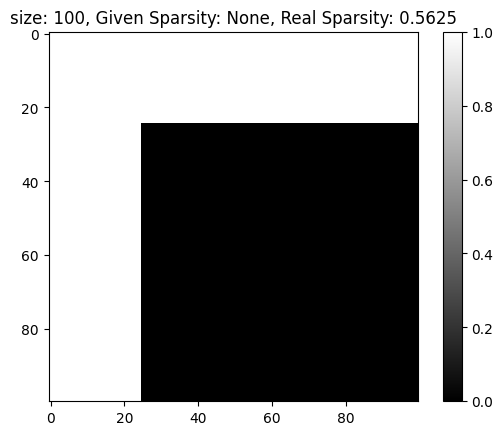

In [130]:
def test_generate_matrix_with_global_attention_mask():
    size = 100
    global_width = 25
    matrix = generate_matrix_with_global_attention_mask(size=size, global_width=global_width)
    show_matrix_infos(matrix=matrix, size=size)
    
test_generate_matrix_with_global_attention_mask()

In [131]:
def best_global_width_from_sparsity(size, sparsity):
    n = size
    density = 1.0 - sparsity
     # ideal diagonal aera
    ga = n * n * density
    # same as window mask but easier
    a = -1
    b = 2 * n
    c = - ga
    det = b * b - 4 * a * c
    x = (-b + math.sqrt(det))/(2 * a)
    gw = round(x)
    if(gw < 0) : gw = 0
    elif(gw > n * n ): gw = n * n
    return gw 

In [132]:
def test_global_width_from_sparsity():
    sparsity_values = [x / 100.0 for x in range(0, 101, 5)]
    sizes = [10, 100, 250, 500, 1000]
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    
    plt.figure(figsize=(6, 6))

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='y=x')

    for size, color in zip(sizes, colors):
        given_sparsity = []
        real_sparsity = []
        
        for sparsity in sparsity_values:
            ga = best_global_width_from_sparsity(size, sparsity)
            real_sp = 1.0 - (float(global_attention_aera(size, ga)) / float(size * size))
            given_sparsity.append(sparsity)
            real_sparsity.append(real_sp)
        
        plt.plot(given_sparsity, real_sparsity, 'o-', color=color, label=f'n={size}')
    plt.xlabel('Given Sparsity')
    plt.ylabel('Real Sparsity')
    plt.legend()
    plt.grid(True)
    plt.show()

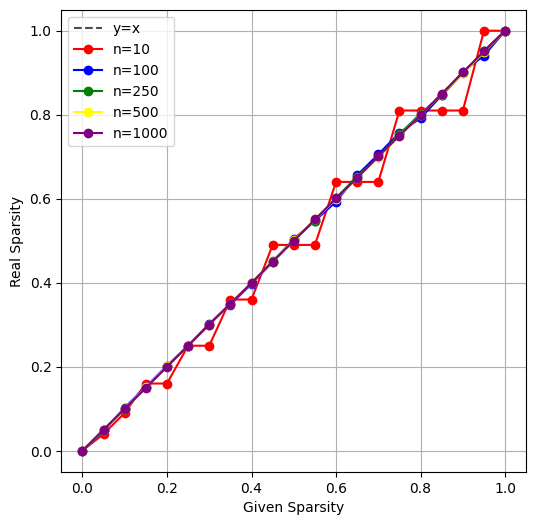

In [133]:
# test function hided for render
test_global_width_from_sparsity()

In [134]:
def get_global_attention_mask_with_sparsity( size, sparsity):
    # conditions : 0 <= sparsity <= 1
    gw = best_global_width_from_sparsity(size, sparsity)
    return get_global_attention_mask( size=size, global_width=gw)

In [135]:
def generate_matrix_with_global_attention_mask_with_sparsity(size, sparsity):
    matrix = np.ones((size, size))
    mask = get_global_attention_mask_with_sparsity(size=size, sparsity=sparsity)
    matrix[~mask] = 0
    return matrix

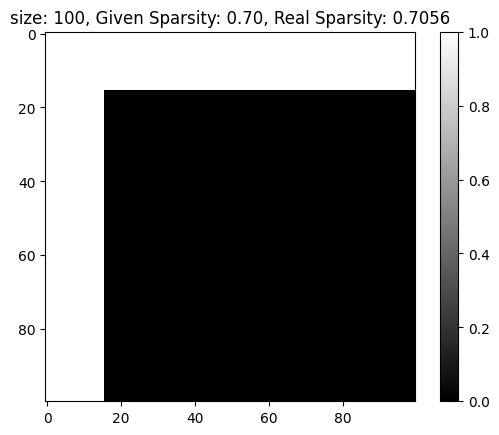

In [136]:
def test_generate_matrix_with_global_attention_mask_with_sparsity():
    size = 100
    sparsity = 0.7
    matrix = generate_matrix_with_global_attention_mask_with_sparsity(size=size, sparsity=sparsity)
    show_matrix_infos(matrix=matrix, size=size, given_sparsity= sparsity)
    
test_generate_matrix_with_global_attention_mask_with_sparsity()

## BIG BIRD (combination of all above)

In [137]:
def get_big_bird_mask(size, nz_per_row, diagonal_width, global_width):
    am = get_random_attention_mask( size= size, nz_per_row=nz_per_row)
    wm = get_window_attention_mask( size= size, diagonal_width=diagonal_width)
    gm = get_global_attention_mask( size=size, global_width= global_width)
    total_mask = am | wm | gm 
    return total_mask

In [138]:
def generate_big_bird(size, nz_per_row, diagonal_width, global_width ):
    matrix = np.ones((size, size))
    mask = get_big_bird_mask( size=size, nz_per_row= nz_per_row, diagonal_width=diagonal_width, global_width= global_width)
    matrix[~mask] = 0
    return matrix

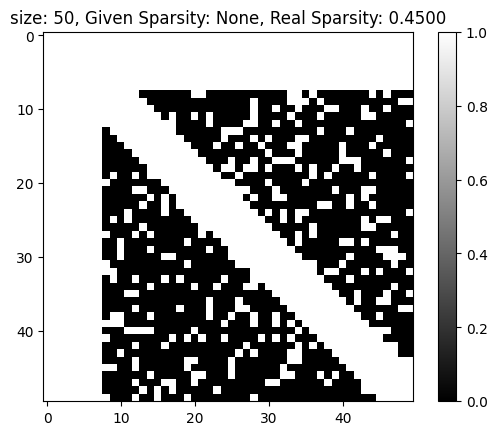

In [139]:
def test_generate_big_bird():
    size = 50
    nz_per_row = 10
    diagonal_width = 8
    global_width = 8
    matrix = generate_big_bird(size=size,nz_per_row=nz_per_row, diagonal_width=diagonal_width, global_width=global_width)
    show_matrix_infos(matrix=matrix, size= size)
    
test_generate_big_bird()

In [140]:
def get_big_bird_mask_with_sparsity( size, random_sparsity, window_sparsity, global_sparsity):
    am = get_random_attention_mask_with_sparsity( size= size, sparsity=random_sparsity)
    wm = get_window_attention_mask_with_sparsity( size= size,sparsity=window_sparsity )
    gm = get_global_attention_mask_with_sparsity(size=size, sparsity=global_sparsity)
    total_mask = am | wm | gm 
    return total_mask

In [141]:
def generate_big_bird_with_sparsity(size, random_sparsity, window_sparsity, global_sparsity):
    matrix = np.ones((size, size))
    mask = get_big_bird_mask_with_sparsity(size, random_sparsity, window_sparsity, global_sparsity)
    matrix[~mask] = 0
    return matrix

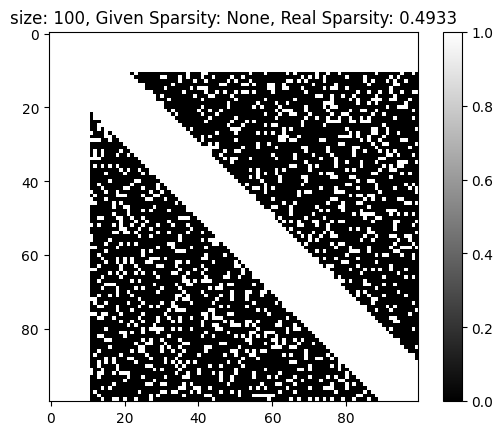

In [142]:
def test_generate_big_bird_with_sparsity():
    size = 100
    random_sparsity =  0.8
    window_sparsity = 0.8
    global_sparsity = 0.8
    matrix = generate_big_bird_with_sparsity(size=size,random_sparsity=random_sparsity, window_sparsity=window_sparsity, global_sparsity=global_sparsity)
    show_matrix_infos(matrix=matrix, size= size)
    
test_generate_big_bird_with_sparsity()

In [143]:
def adjust_total_sparsity(total_sparsity):
    x = total_sparsity
    # degree = 3
    # a = 2.61815675
    # b = -4.77052715
    # c = 2.98999146
    # d = 0.19945692
    # res =  a  * ( x ** 3 )  + b * (x ** 2) + c * x
    # degree = 5
    a = 24.08862473
    b = -65.2963488
    c = 64.48601296
    d = -28.42365239 
    e = 5.98076684
    f = 0.17082526
    poly =  a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f
    res = min(max(poly, 0.0), 1.0)
    return res

In [144]:
def get_big_bird_mask_with_total_sparsity( size, total_sparsity, adjust):
    if adjust :
        total_sparsity = adjust_total_sparsity(total_sparsity)
    random_sparsity = total_sparsity
    window_sparsity = total_sparsity
    global_sparsity = total_sparsity
    total_mask = get_big_bird_mask_with_sparsity( size, random_sparsity, window_sparsity, global_sparsity)
    return total_mask

In [145]:
def generate_big_bird_with_total_sparsity(size,total_sparsity, adjust):
    matrix = np.ones((size, size))
    mask = get_big_bird_mask_with_total_sparsity(size, total_sparsity, adjust)
    matrix[~mask] = 0
    return matrix

In [146]:
def find_approximation():
    sparsity_values = [x / 100.0 for x in range(0, 101, 5)]
    size = 2000
    
    given_sparsity = []
    real_sparsity = []
    
    for sparsity in sparsity_values:
        matrix = generate_big_bird_with_total_sparsity(size, sparsity, adjust=False)
        real_sp = get_sparsity(matrix, size)
        given_sparsity.append(sparsity)
        real_sparsity.append(real_sp)
    
    sort_idx = np.argsort(real_sparsity)
    real_sorted = np.array(real_sparsity)[sort_idx]
    given_sorted = np.array(given_sparsity)[sort_idx]
    
    coeffs = np.polyfit(real_sorted, given_sorted, 5)
    
    print(f"a = {coeffs[0]}")
    print(f"b = {coeffs[1]}")
    print(f"c = {coeffs[2]}")
    print(f"d = {coeffs[3]}")
    print(f"e = {coeffs[4]}")
    print(f"f = {coeffs[5]}")
    print(f"poly = a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f")

find_approximation()

a = 24.09415949505001
b = -65.30036129778037
c = 64.47572088736197
d = -28.411447168124422
e = 5.977174484231452
f = 0.17098672126501577
poly = a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f


Given sparsity = 0.8


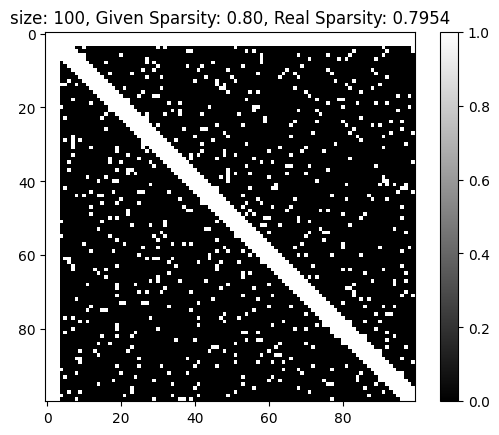

In [147]:
def test_generate_big_bird_with_total_sparsity():
    size = 100
    total_sparsity = 0.8
    adjust = True
    matrix = generate_big_bird_with_total_sparsity(size, total_sparsity, adjust)
    print(f"Given sparsity = {total_sparsity}")
    show_matrix_infos(matrix, size, given_sparsity= total_sparsity)
    
test_generate_big_bird_with_total_sparsity()

In [148]:
def test_adjust_total_sparsity(adjust):
    sparsity_values = [x / 100.0 for x in range(0, 101, 5)]
    sizes = [10, 100, 250, 500, 1000 ]
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=1, label='y=x')
    for size, color in zip(sizes, colors):
        given_sparsity = []
        real_sparsity = []
        
        for sparsity in sparsity_values:
            matrix = generate_big_bird_with_total_sparsity(size, sparsity, adjust= adjust)
            real_sp = get_sparsity(matrix, size)
            given_sparsity.append(sparsity)
            real_sparsity.append(real_sp)
        
        plt.plot(given_sparsity, real_sparsity, 'o-', color=color, linewidth=1, markersize=3, label=f'n={size}')  

    plt.xlabel('Given Sparsity')
    plt.ylabel('Real Sparsity')
    plt.legend()
    plt.grid(True)
    plt.show()

Without adjusting :


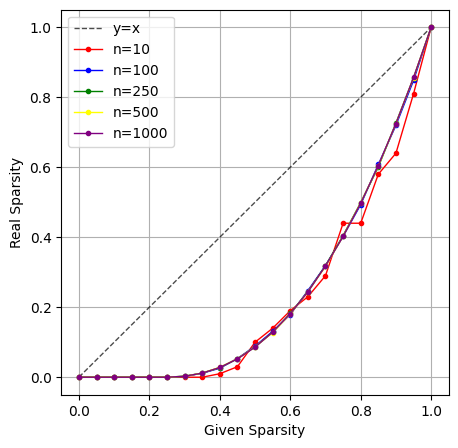

When adjusting the given sparsity : 


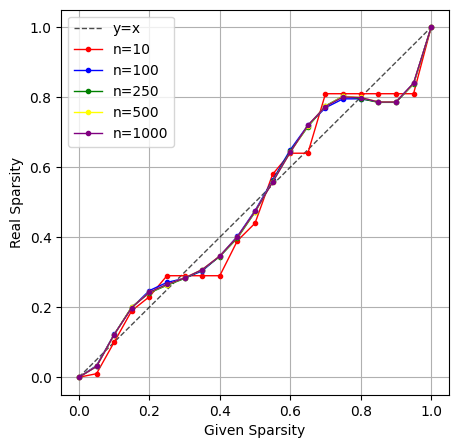

In [149]:
# def test_adjust_total_sparsity(adjust):
# ... (hided for rendering)

print("Without adjusting :")
test_adjust_total_sparsity(False)
print("When adjusting the given sparsity : ")
test_adjust_total_sparsity(True)

## C code :

```c

#include <omp.h>
#include <stdio.h>
#include <stdlib.h>
#include <stdbool.h>
#include <math.h>

//UTILS

static inline int min(int a, int b) {
    return a < b ? a : b;
}

static inline int max(int a, int b) {
    return a > b ? a : b;
}

void print_matrix_int(int* matrix, int size){
    int row, columns;
    for (row=0; row<size; row++)
    {
        for(columns=0; columns<size; columns++)
        {
            if(matrix[row * size + columns] == 1){
                printf("\033[32m1 \033[0m");
            } else {
                printf("\033[31m0 \033[0m");
            }
        }
        printf("\n");
    }
    printf("\n \n");
}

int* init_matrix_int( int size, int value ){
    int* res = (int *)malloc(sizeof(int) * size * size) ; 
    int row, columns;
    for (row=0; row<size; row++)
    {
        for(columns=0; columns<size; columns++)
        {
         res[row * size + columns] = value;
        }
    }
    return res ; 
}

void print_matrix_bool(bool* bmask, int size){
    int row, columns;
    for (row=0; row<size; row++)
    {
        for(columns=0; columns<size; columns++)
        {
            if (bmask[row * size + columns]){
                printf("\033[32mT \033[0m");
            }
            else {
                printf("\033[31mF \033[0m");
            }
        }
        printf("\n");
    }
    printf("\n \n");
}

bool* init_matrix_bool( int size, bool value ){
    bool* res = (bool *)malloc(sizeof(bool) * size * size) ; 
    int row, columns;
    for (row=0; row<size; row++)
    {
        for(columns=0; columns<size; columns++)
        {
         res[row * size + columns] = value;
        }
    }
    return res ; 
}

void set_boolean_mask_from_range(bool* bmask, int size, int ymin, int ymax, int xmin, int xmax, bool value){
    int row, columns;
    for (row=ymin; row< ymax; row++)
    {
        for(columns=xmin; columns<xmax; columns++)
        {
         bmask[row * size + columns] = value;
        }
    }
}

void apply_boolean_mask(int* matrix, bool* b_mask, int size){
    int row, columns;
    for (row=0; row<size; row++)
    {
        for(columns=0; columns<size; columns++)
        {
         if(b_mask[row * size + columns] == false){
            matrix[row * size + columns] = 0 ;
         }
        }
    }
}



int* get_unique_random_number(int count, int min, int max) {
    int range = max - min;
    int candidates[range];
    int* result = malloc(count * sizeof(int));
    int i;
    
    for (i = 0; i < range; i++)
    candidates[i] = i + min;
    
    for (i = 0; i < range - 1; i++) {
        int c = rand() / (RAND_MAX / (range - i) + 1);
        int t = candidates[i];
        candidates[i] = candidates[i + c];
        candidates[i + c] = t;
    }
    
    for (i = 0; i < count; i++){
        result[i] = candidates[i];
    }
    
    return result;
}

// ACTUAL FUNCTIONS

// RANDOM ATTENTION MASK

bool* get_random_attention_mask(int size, int nz_per_row){
    bool* res = init_matrix_bool(size, false);
    int* unique_random_number ; 
    int row, columns;
    for (row=0; row < size; row++)
    {
        unique_random_number = get_unique_random_number(nz_per_row, 0, size);
        for(columns = 0; columns < nz_per_row; columns++)
        {
            int indice = unique_random_number[columns] ; 
            res[row * size + indice] = true; 
        }
        free(unique_random_number);
    }
    return res ; 
}

int best_nz_per_row_from_sparsity(int size, double sparsity){
    int res = round((float)size * (1.0 - sparsity));
    return res ; 
}

bool* get_random_attention_mask_with_sparsity(int size, double sparsity){
    int nz_per_row = best_nz_per_row_from_sparsity(size, sparsity); 
    return get_random_attention_mask(size, nz_per_row); 
}

// WINDOW ATTENTION

bool* get_window_attention_mask(int size, int diagonal_width){
    bool* res = init_matrix_bool(size, false);
    int row, columns;
    if(diagonal_width > 0){
        int sdw = diagonal_width / 2 ; 
        for (row=0; row < size; row++)
        {
            int min_c = max(0, row - sdw ); 
            int max_c = min(size - 1, row + sdw ); 
            for(columns = min_c; columns <= max_c ; columns++)
            {
                res[row * size + columns] = true ; 
            }
        }
    }
    return res ; 
}

int best_diagonal_width_from_sparsity(int size, double sparsity){
    int n = size;
    double density = 1.0 - sparsity;
    double da = n * n * density;
    double a = -1;
    double b = 2 * n - 1;
    double c = n - da;
    double det = b * b - 4 * a * c;
    double x = (-b + sqrt(det))/(2 * a);
    
    int sdw = round(x);
    
    int dw = 2 * sdw + 1;
    
    if(dw < 0) dw = 0;
    else if(dw > 2*n - 1) dw = 2*n - 1;
    
    return dw;
}

bool* get_window_attention_mask_with_sparsity(int size, double sparsity){
    int dw = best_diagonal_width_from_sparsity(size, sparsity);
    return get_window_attention_mask( size, dw);
}

// GLOBAL ATTENTION

bool* get_global_attention_mask( int size, int global_width){
    bool* res = init_matrix_bool(size, false) ; 
    set_boolean_mask_from_range(res, size, 0 , global_width, 0, size, true);
    set_boolean_mask_from_range(res, size, global_width , size , 0, global_width, true);
    return res ; 
}

int best_global_width_from_sparsity(int size, double sparsity){
    int n = size;
    double density = 1.0 - sparsity;
    double ga = n * n * density;
    double a = -1;
    double b = 2 * n;
    double c = -ga;
    double det = b * b - 4 * a * c;
    double x = (-b + sqrt(det))/(2 * a);
    int gw = round(x);
    if(gw < 0) gw = 0;
    else if(gw > n * n) gw = n * n;
    return gw;
}

bool* get_global_attention_mask_with_sparsity(int size, double sparsity){
    int gw = best_global_width_from_sparsity(size, sparsity);
    return get_global_attention_mask(size, gw); 
}

// BIG BIRD

bool* combine_all_mask(int size, bool* random_mask, bool* window_mask, bool* global_mask){
    bool* res = (bool *)malloc(sizeof(bool) * size * size) ; 
    int row, columns;
    for (row=0; row<size; row++)
    {
        for(columns=0; columns<size; columns++)
        {
            res[row * size + columns] = random_mask[row * size + columns] | window_mask[row * size + columns] | global_mask[row * size + columns] ; 
        }
    }
    return res ; 
}

bool* get_big_bird_mask(int size, int nz_per_row, int diagonal_width, int global_width){
    bool* am = get_random_attention_mask(size, nz_per_row);
    bool* wm = get_window_attention_mask(size, diagonal_width);
    bool* gm = get_global_attention_mask(size, global_width);
    bool* res = combine_all_mask(size, am, wm, gm);
    free(am);
    free(wm);
    free(gm);
    return res;
}

bool* get_big_bird_mask_with_sparsity(int size, double random_sparsity, double window_sparsity, double global_sparsity){
    bool* am = get_random_attention_mask_with_sparsity(size, random_sparsity);
    bool* wm = get_window_attention_mask_with_sparsity(size, window_sparsity);
    bool* gm = get_global_attention_mask_with_sparsity(size, global_sparsity);
    bool* res = combine_all_mask(size, am, wm, gm);
    free(am);
    free(wm);
    free(gm);
    return res;
}

double adjust_total_sparsity(double total_sparsity){
    double x = total_sparsity;
    double a = 24.08862473;
    double b = -65.2963488;
    double c = 64.48601296;
    double d = -28.42365239;
    double e = 5.98076684;
    double f = 0.17082526;
    double poly = a * pow(x, 5) + b * pow(x, 4) + c * pow(x, 3) + d * pow(x, 2) + e * x + f;
    if(poly < 0.0){
        poly = 0.0;
    }
    else {
        if(poly > 1.0){
            poly = 1.0;
        }
    }
    return poly;
}

bool* get_big_bird_mask_with_total_sparsity(int size, double total_sparsity, bool adjust){
    if(adjust){
        total_sparsity = adjust_total_sparsity(total_sparsity);
    }
    return get_big_bird_mask_with_sparsity(size, total_sparsity, total_sparsity, total_sparsity);
}

int main(int argc, char* argv[])
{
    int size = 25;
    double total_sparsity = 0.7;
    bool* b_mask = get_big_bird_mask_with_total_sparsity(size, total_sparsity, true);
    int* big_bird_matrix = init_matrix_int(size, 1); 
    apply_boolean_mask(big_bird_matrix, b_mask, size); 
    print_matrix_int(big_bird_matrix, size) ;
    free(big_bird_matrix); 
    free(b_mask); 
}
```

And execution :
```bash
make
# gcc -Wall -fopenmp -o big_bird big_bird.c -lm
./big_bird
```

![exe](./c_exe.png)